# neuroBrite 2020 - Behaviour notebook

This notebook allows you to collect behavioural data (accuracy and reaction time) and analyse it.

In the task you will see images of faces and buildings. Most of the faces will be adults but occasionally we will present baby faces. Most of the buildings with be houses but occasionally we will present images of castles. There are three versions of the task.

1. Count how many baby faces are presented
2. Count how many castles are presented
3. Count both faces *and* castles

In all versions of the task you should press one key for faces (of any age) and one key for buildings (of any type).

In [8]:
# this cell loads the things we will need (make sure to run this!)
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
#from mne import Epochs, find_events
from time import time, strftime, gmtime
import os, glob
import pandas as pd
from stimulus_presentation import nb2020_rt
#from utils import utils
#from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Run the experiment

The cell below runs the experiment:

- Press the `z` key in response to faces
- Press the `m` key in response to buildings

Try to respond as quickly and as accurately as possible!

In [5]:
subject = 1
session = 1
duration = 20

nb2020_rt.present(duration=duration, subj_num=subject, sess_num=session)

/Users/stephenrhodes/eeg-notebooks/notebooks/stimulus_presentation/stim/nb2020
222.3917 	WARNING 	User requested fullscreen with size [1600  900], but screen is actually [1280, 800]. Using actual size


# Read the data

In [10]:
# enter the subject and session number you want to load
subject = 1
session = 1

data_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", 
                         "nb2020_rt", "subject" + str(subject), "session" + str(session)) + "/"

# combine all data files
all_filenames = [i for i in glob.glob(data_path + '*.{}'.format("csv"))]
all_data = pd.concat([pd.read_csv(f) for f in all_filenames])

# drop missing values
clean_data = all_data.dropna()

print("%.2f%% missing data (no response given)" % (100*(1 - len(clean_data.index)/ len(all_data.index))) )

# add column for accuracy
# image_type = 1 = faces
clean_data["resp_type"] = pd.Series(clean_data.resps == 'z', index=clean_data.index, dtype='int64') 
clean_data["acc"] = pd.Series(clean_data.resp_type == clean_data.image_type, index=clean_data.index, dtype='int64') 

# aggregate data
agg_data = clean_data.groupby("mark").agg(
    {
         'rts': ['count', 'mean', 'std', 'sem'],
        'acc': ['count', 'mean', 'std', 'sem']
    }
)

agg_data


84.73% missing data (no response given)


rts                                 acc                              
     count      mean       std       sem count      mean       std       sem
mark                                                                        
0       18  0.450432  0.067811  0.015983    18  0.888889  0.323381  0.076222
1        3  0.407072  0.078859  0.045529     3  1.000000  0.000000  0.000000
2       19  0.436420  0.060840  0.013958    19  0.842105  0.374634  0.085947
3        2  0.517818  0.117865  0.083343     2  0.500000  0.707107  0.500000

# Reaction times

The plot below shows average reaction time for the two types of face stimuli and the two types of buildings.

Which stimuli elicit the fastest and slowest reaction times?

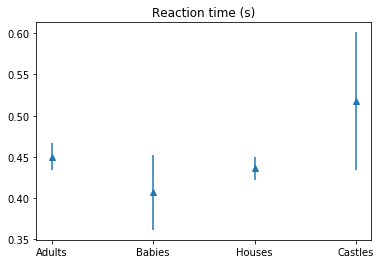

In [20]:
stim_labels = ["Adults","Babies","Houses","Castles"]

mean_rt = agg_data["rts"]['mean'] # average reaction time
se_rt = agg_data["rts"]['sem'] # standard error (measure of how uncertain we are about the average)

plt.figure()
plt.errorbar(stim_labels, mean_rt, se_rt, linestyle='None', marker='^')
plt.title('Reaction time (s)')
plt.show()

# Accuracy

The plot below shows accuracy for the two types of face stimuli and the two types of buildings.

Were participants more or less accurate for specific stimuli?

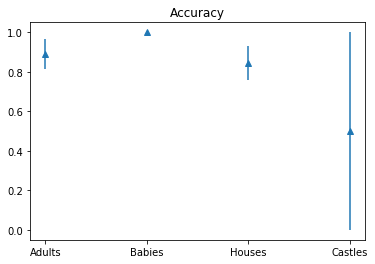

In [21]:

mean_acc = agg_data["acc"]['mean'] # average accuracy
se_acc = agg_data["acc"]['sem'] # uncertainty in the average

plt.figure()
plt.errorbar(stim_labels, mean_acc, se_acc, linestyle='None', marker='^')
plt.title('Accuracy')
plt.show()
